# Exercise 7 - Python: $k$-means Clustering and Principle Component Analysis

<img width="350px" src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif">

## *Part I*: $k$-means Clustering

$k$-means clustering is an [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning) technique that assigns training data to different clusters.  It does this by assigning $k$ cluster centers (or centroids) at random, assigning the closest points of the training data to that cluster, calculating the mean of that cluster, and re-adjusting the centroid to that mean.  It then does this over and over again for the number of iterations specified.

In this section, we'll build the $k$-means clustering algorithm, and then use it for both a simple 2d data set and on an image in order to compress it by reducing the overall number of colors used.

---

Beginning with package imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.io as sio  # Used to load the Octave/MATLAB *.mat files
from math import floor, ceil

%matplotlib inline

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

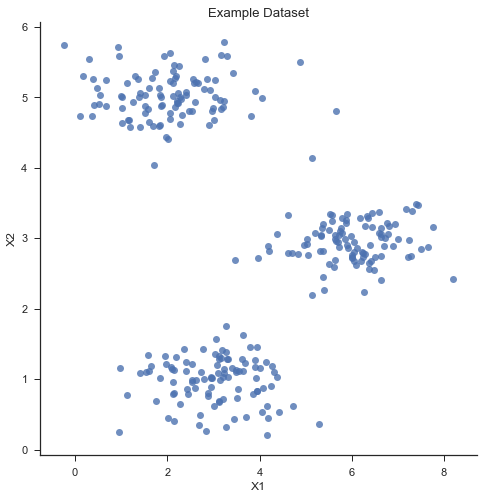

In [2]:
# Loading data and putting it into a data frame for plotting
X = sio.loadmat('ex7/ex7data2.mat')['X']
df = pd.DataFrame(X, columns=['X1', 'X2'])

# Visualizing data
sns.lmplot('X1', 'X2', data=df, fit_reg=False, size=7)
plt.title('Example Dataset');

### Implementing $k$-means

The first step is usually initializing the centroids with random values, but we are provided with initial centroids for 

#### Finding Closest Centroids

This step assigns the points in the training data to the clusters of the closest centroids.  After this is accomplished, we'll re-calculate the centroids using the mean value of each point belonging to that cluster in the training data.

For every example $i$, set:

$$c^{(i)} := j\ \text{that minimizes}\ \|x^{(i)} - \mu_j \|^2
\\
c^{(i)}: \text{Index of the centroid that is closest to}\ x^{(i)}\ 
\\
\mu_j: \text{Position (value) of the}\ j\text{'th centroid}$$

In [3]:
def assign_centroid(X, centroids):
    """
    Assigns a cluster number to each row of a data set
    """

    # Creating a function for finding the clusters per record
    def find_centroid(X, centroids):
        """
        Finds the centroid with the lowest squared error for an
        individual record
        """
        # Calculating the squared error for each centroid
        error = np.sum((X - centroids)**2, axis=1)
        
        # Finding the index with the minimum error
        cluster = np.argmin(error) + 1  # Adjusts for 0-indexing
        
        return cluster

    # Applying function to all rows
    # Checks X object type in order to perform the correct operation
    if isinstance(X, pd.DataFrame):
        clusters = X.apply(
            lambda x: find_centroid(x.values, centroids), axis=1)
    else:
        clusters = np.apply_along_axis(
            find_centroid, axis=1, arr=X, centroids=centroids)

    return clusters


# Creating initial centroids in order to test the function
initialCentroids = np.array([[3, 3], [6, 2], [8, 5]])

# Testing the function
assign_centroid(X, initialCentroids)[:3]

array([1, 3, 2], dtype=int64)

Let's run a quick visualization to display our results using the initial centroids:

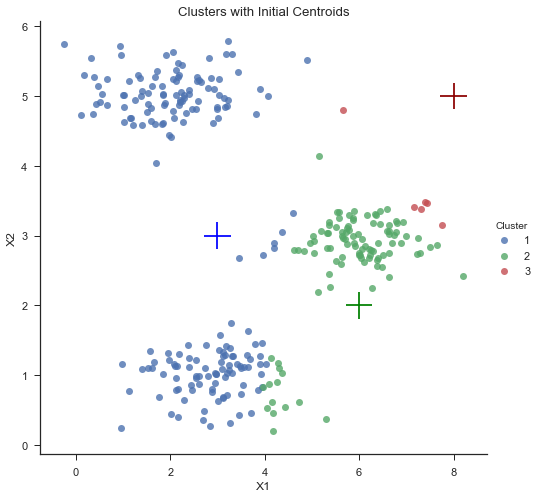

In [4]:
# Assigning cluster numbers to the training data
clusters = assign_centroid(X, initialCentroids)
df['Cluster'] = clusters

# Visualizing the results of the data
sns.lmplot('X1', 'X2', hue='Cluster', data=df, fit_reg=False, size=7)


# Adding X marks for the centroids
# Converting to data frame for easier plotting
initialCentroidsPlotting = pd.DataFrame(initialCentroids)

# Adding colors to match the seaborn colors
initialCentroidsPlotting['Cluster'] = ['b', 'g', 'darkred']

# Plotting the centroids themselves
plt.scatter(x=initialCentroidsPlotting[0], y=initialCentroidsPlotting[1],
           marker='+', s=700, c=initialCentroidsPlotting['Cluster'])


plt.title('Clusters with Initial Centroids')

#### Computing Centroid 

This is the next step to $k$-means clustering that is used to re-assign centroids.  We do this by merely calculating the mean of the points belonging to each cluster.

For every centroid $k$, set:

$$\mu_k := \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}
\\
C_k: \text{Set of examples that are assigned to centroid }k$$

In [5]:
def compute_centroids(X, clusters):
    """
    Finds the new centroids by calculating the average value of all
    points contained within each cluster
    """
    
    # Empty matrix of new centroids to be filled
    centroids = np.zeros([np.unique(clusters).shape[0],
                          X.shape[1]])
    
    # Looping through the clusters to calculate the mean
    for i, cluster in enumerate(np.unique(clusters)):
        clusterIdx = np.where(clusters == cluster)  # Index matching
        subset = X[clusterIdx]  # Subsetting
        newCentroid = subset.mean(axis=0)  # Calculating the mean
        centroids[i] = newCentroid  # Assigning the new centroid
    
    return centroids


compute_centroids(X, clusters)

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

Note that we could also do this with a simple groupby operation on a pandas data frame:

In [6]:
df.groupby(df['Cluster']).mean()

,X1,X2
Cluster,,
1,2.428301,3.157924
2,5.813503,2.633656
3,7.119387,3.616684


### $k$-means on example dataset

Now that we've built the steps for the algorithm, let's run it on the example dataset.

The code in this section is a little longer in order to produce a graph that shows the steps our algorithm takes for each iteration.

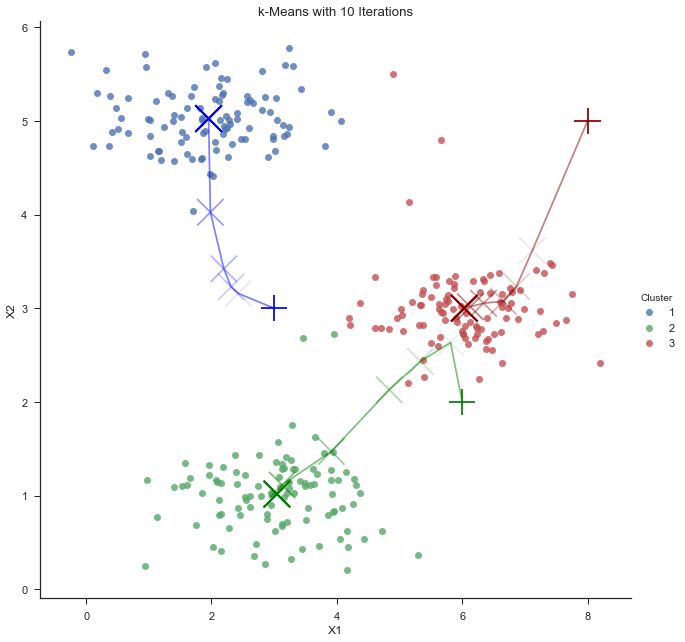

In [7]:
# Setting up names for loop
centroids = initialCentroids
centroidsPlot = initialCentroidsPlotting
centroidsPlot['k'] = 0

# Number of k
iterations = 10

# Looping through the iterations to find the centroids and assign clusters
for k in np.arange(1, iterations + 1):  # Adjusting indexes for k
    # Performing k-means
    clusters = assign_centroid(X, centroids)
    centroids = compute_centroids(X, clusters)

    # Putting results into a data frame for plotting
    plotting = pd.DataFrame(centroids)
    plotting['Cluster'] = ['b', 'g', 'darkred']
    plotting['k'] = k
    centroidsPlot = centroidsPlot.append(plotting)

# Assigning final cluster numbers to the training data
clusters = assign_centroid(X, centroids)
df['Cluster'] = clusters

# Visualizing the results of the data
sns.lmplot('X1', 'X2', hue='Cluster', data=df, fit_reg=False, size=9)

# Plotting the initial centroids
plt.scatter(
    x=initialCentroidsPlotting[0],
    y=initialCentroidsPlotting[1],
    c=initialCentroidsPlotting['Cluster'],
    marker='+',
    s=700)

# Plotting all centroids
# Looping through to assign different values of alpha to each iteration
for k in np.arange(1, iterations + 1):
    subset = centroidsPlot[centroidsPlot['k'] == k]
    plt.scatter(
        x=subset[0],
        y=subset[1],
        c=subset['Cluster'],
        alpha=subset['k'].mean() / 10,
        marker='x',
        s=700)

# Plotting the lines connecting the centroids
# Looping through to assign different colors for each cluster
for cluster in centroidsPlot['Cluster'].unique():
    subset = centroidsPlot[centroidsPlot['Cluster'] == cluster]
    plt.plot(subset[0], subset[1], c=cluster, alpha=0.5)
    

plt.title('k-Means with 10 Iterations')

### Random Initialization

We were provided with initial centroids for the previous parts of the exercise, but it's prudent to use random starting points (in addition to multiple runs that use different starting points) to avoid falling into a local minima.

In [8]:
def initialize_centroids(X, clusters=1):
    """
    Generates random values for initial centroids
    """
    centroids = np.random.uniform(low=X.min(),
                                  high=X.max(),
                                  size=[clusters, X.shape[1]])
    return centroids


initialize_centroids(X, clusters=3)

array([[ 2.74239336,  0.34396792],
       [ 4.0313562 ,  4.46346981],
       [ 5.95052688,  5.21892629]])

### Image Compression with $k$-means

We'll apply $k$-means to an image in order to compress it from a 24-bit color representation (where each pixel is made up of three 8-bit integers ranging from 0 to 255) made up of thousands of colors to just 16 colors.

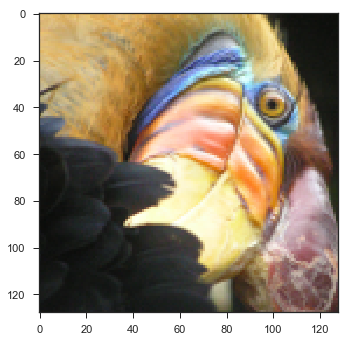

In [9]:
# Plotting the image to be compressed
img = mpimg.imread('ex7/bird_small.png')
plt.imshow(img)

In [10]:
# Reading in the matrix of pixels
data = sio.loadmat('ex7/bird_small.mat')['A']
print(data.shape)

# Flattening to have one row for each pixel
X = np.reshape(data, newshape=(data.shape[0] * data.shape[1], data.shape[2]))
print(X.shape)

# Normalizing each pixel so they're in between the range of 0 - 1
X = X / 255

(128, 128, 3)
(16384, 3)


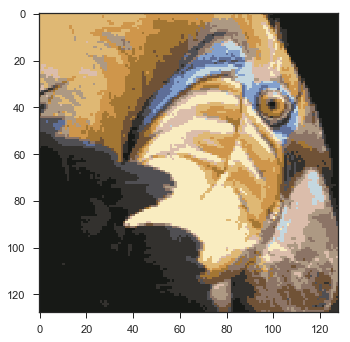

In [11]:
# Generating initial centroids for the 16 colors/clusters
centroids = initialize_centroids(X, clusters=16)

iterations = 10

# Looping through the iterations to find the centroids and assign clusters
for k in range(iterations):  # Adjusting indexes for k
    # Performing k-means
    clusters = assign_centroid(X, centroids)
    centroids = compute_centroids(X, clusters)

# Assigning the training data to clusters using the final centroids
clusters = assign_centroid(X, centroids)

# Adjusting back to 0-based indexing for np.take() function
clusters = clusters - 1

# Assigns each pixel to the centroid of its cluster
# This reduces it to 16 total colors
compressed_image = np.take(centroids, clusters, axis=0)

# Reshaping to the original image shape
compressed_image = compressed_image.reshape(
    [data.shape[0], data.shape[1], data.shape[2]])

# Plotting the compressed image
plt.imshow(compressed_image)

---

##  *Part II:* Principal Component Analysis

**[Discuss section here]**

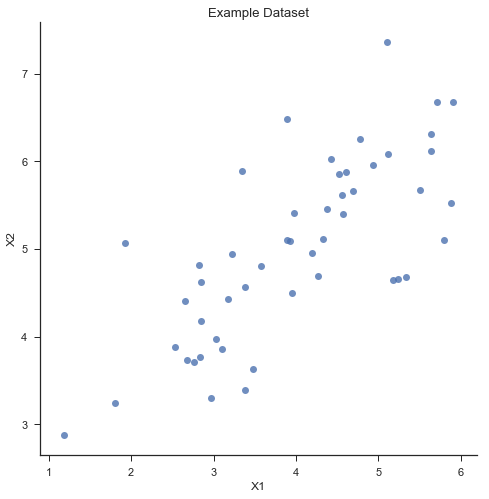

In [12]:
# Loading data and putting it into a data frame for plotting
X = sio.loadmat('ex7/ex7data1.mat')['X']
df = pd.DataFrame(X, columns=['X1', 'X2'])

# Visualizing data
sns.lmplot('X1', 'X2', data=df, fit_reg=False, size=7)
plt.title('Example Dataset');

### Implementing PCA

Implementing PCA consists of three steps:
1. Normalize the data
2. Compute the covariance matrix of the data
3. Perform [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) to acquire the eigenvectors that correspond to the principal components of variation

#### Normalizing the Data

$$x' = \frac{x - \bar{x}}{\sigma}$$

In [13]:
def standard_scaler(x):
    """
    Scales data between 0 and 1
    """
    xScaled = (x - x.mean()) / x.std()

    return xScaled

#### Computing the Covariance Matrix

$$\sum = \frac{1}{m} X^T X
\\
X: \text{Data matrix with examples in rows}
\\
m: \text{Number of examples}
\\
\sum: n \times n\ \text{matrix (and not a summation operator)}$$

In [14]:
def covariance_matrix(X):
    """
    Returns the covariance matrix 
    """
    m = X.shape[0]  # Parameter used for calculation
    X = standard_scaler(X)  # Scaling data before covariance
    X = np.matrix(X)
    covariance = (1/m) * (X.T * X)  # Calculating covariance
    
    return covariance


covariance_matrix(X)

matrix([[ 1.11151143,  0.4213388 ],
        [ 0.4213388 ,  0.88848857]])

#### Singular Value Decomposition

In [15]:
def pca(X):
    """
    Wrapper for numpy's singular value decomposition function
    Calls covariance matrix on the back end, thus resulting in PCA
    """
    pca =  np.linalg.svd(covariance_matrix(X))
    return pca


pca(X)

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([ 1.43584536,  0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

### Dimensionality Reduction with PCA

#### Projecting Data onto Principal Components

#### Reconstructing an Approximation of the Data

#### Visualizing the Projections

### Face Image Dataset

In [16]:
X = sio.loadmat('ex7/ex7faces.mat')['X']

X.shape

(5000, 1024)

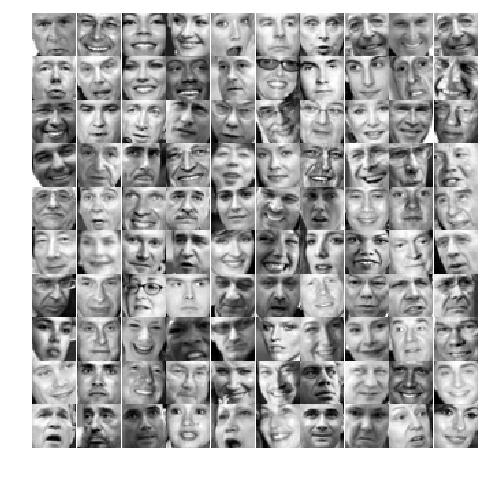

In [17]:
# Randomly sampling 100 faces to display
random100 = X[np.random.randint(X.shape[0], size=100), :]


def plot_faces(faces, width=8, height=8):
    """Plots a grid of the supplied faces"""
    # Creating the overall figure to fill with plots of the numbers
    fig = plt.figure(figsize=(width, height))

    # Calculates the number of columns/rows for the subplot grid
    figShape = np.sqrt(faces.shape[0])

    # Loop over numbers to plot into the overall figure
    for i, face in enumerate(faces):  # Enumerating to include index
        face = face.reshape(32, 32).T  # Reshape X into 32x32 array
        ax = fig.add_subplot(floor(figShape),  # Rows
                             ceil(figShape),  # Columns
                             i + 1)  # Positioning
        plt.imshow(face, cmap='gray')  # Plotting the face

        # Removing unnecessary components for aesthetics
        plt.grid(False)
        plt.axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()


plot_faces(faces=random100)

#### PCA on Faces

#### Dimensionality Reduction